## Game play notes
- Player positions run from 0 - 39 (need to mod 40 on every roll)
- 0 - go, 1 = medeter ave, 2 = comm chest ... 39 = boardwalk
- 0 = go, 10 = jail, 20 = free parking, 30 = go to jail
- Railroads in the middle of each lane @ 5, 15, 25, 35
- Utilities 2 away from jails @ 12 & 28
- Tax @ 4 & 38
- Chance at 7, 22, 36
- Community Chest @ 2, 17, 33
    - 1x Go (0)
    - 1x Jail (10)
    - 14x No movement
- Chance has 16 cards
    - 1x Reading Railroad (5)
    - 1x Boardwalk (39)
    - 1x Go (0)
    - 1x Illinois Avenue (24)
    - 1x St. Charles Place (11)
    - 2x nearest Railroad (5, 15, 25, 35)
    - 1x nearest Utility (12, 28)
    - 1x Back 3 Spaces (-3)
    - 1x Go to Jail (10)
    - 6x No movement 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### We define a function to roll both die, set the order of our chance and community chest cards (think of it like a shuffle)

In [16]:
def rollDice():
    first = random.randint(1,6)
    second = random.randint(1,6)
    return (int(first + second), first == second)

def set_chance():
    vals = ['Reading Railroad', 'Boardwalk', 'Go', 'Illinois Avenue', 'St. Charles Place', \
            'Nearest Railroad', 'Nearest Railroad', 'Nearest Utility', 'Back 3 Spaces', 'Go to Jail', \
            'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement']
    random.shuffle(vals)
    return vals

def set_comm_chest():
    vals = ['Go', 'Go to Jail', \
            'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement', \
            'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement'
            ]
    random.shuffle(vals)
    return vals

### We define our chance and community chest functions by the notes above

In [17]:
def chance(curr_loc):
    order = set_chance()
    curr_card = order[0]
    cards_loc_dict = {'Reading Railroad': 5, 'Boardwalk': 39, 'Go': 0, 'Illinois Avenue': 24, \
                      'St. Charles Place': 11, 'Go to Jail': 10, 'No movement': curr_loc,}
    
    if curr_card == 'Nearest Railroad':
        if 5 < curr_loc <= 15:
            curr_loc = 15
        elif 15 < curr_loc <= 25:
            curr_loc = 25
        elif 25 < curr_loc <= 35:
            curr_loc = 35
        else:
            curr_loc = 5

    elif curr_card == 'Nearest Utility':
        if 12 < curr_loc <= 28:
            curr_loc = 28
        else:
            curr_loc = 12
    
    elif curr_card == 'Back 3 Spaces':
        curr_loc -= 3
    
    else:
        curr_loc = cards_loc_dict[curr_card]

    return int(curr_loc)

In [18]:
def comm_chest(curr_loc):
    order = set_comm_chest()
    curr_card = order[0]
    cards_loc_dict = {'Go': 0, 'Go to Jail': 10, 'No movement': curr_loc}
    curr_loc = cards_loc_dict[curr_card]

    return int(curr_loc)

### Here, we simulate the game and tabluate the number of times a player lands on each square

In [45]:
num_players = 4
turns = 100
num_iterations = 100
chance_loc = np.array([7, 22, 36])
comm_chest_loc = np.array([2, 17, 33])
jail = np.zeros(4)
position_count = np.zeros(40)

for n in range(num_iterations):
    player_loc = np.zeros(4)
    for turn in range(turns):  
        double_count = 0
        for player in range(num_players):
            double = True

            if jail[player] > 0:
                die, double = rollDice()
                if double:
                    jail[player] = 0
                pass

            while double and double_count < 3:
                die, double = rollDice()

                if double:
                    double_count += 1

                player_loc[player] = int((player_loc[player] + die) % 40)
                current_loc = int(player_loc[player])
                position_count[current_loc] += 1

                if current_loc in chance_loc:
                    current_loc = chance(current_loc)
                    if current_loc == 10:
                        jail[player] = 3
                
                elif current_loc in comm_chest_loc:
                    current_loc = comm_chest(current_loc)
                    if current_loc == 10:
                        jail[player] = 3
                
                if jail[player] == 3:
                    break

### Create plots and data visualizations

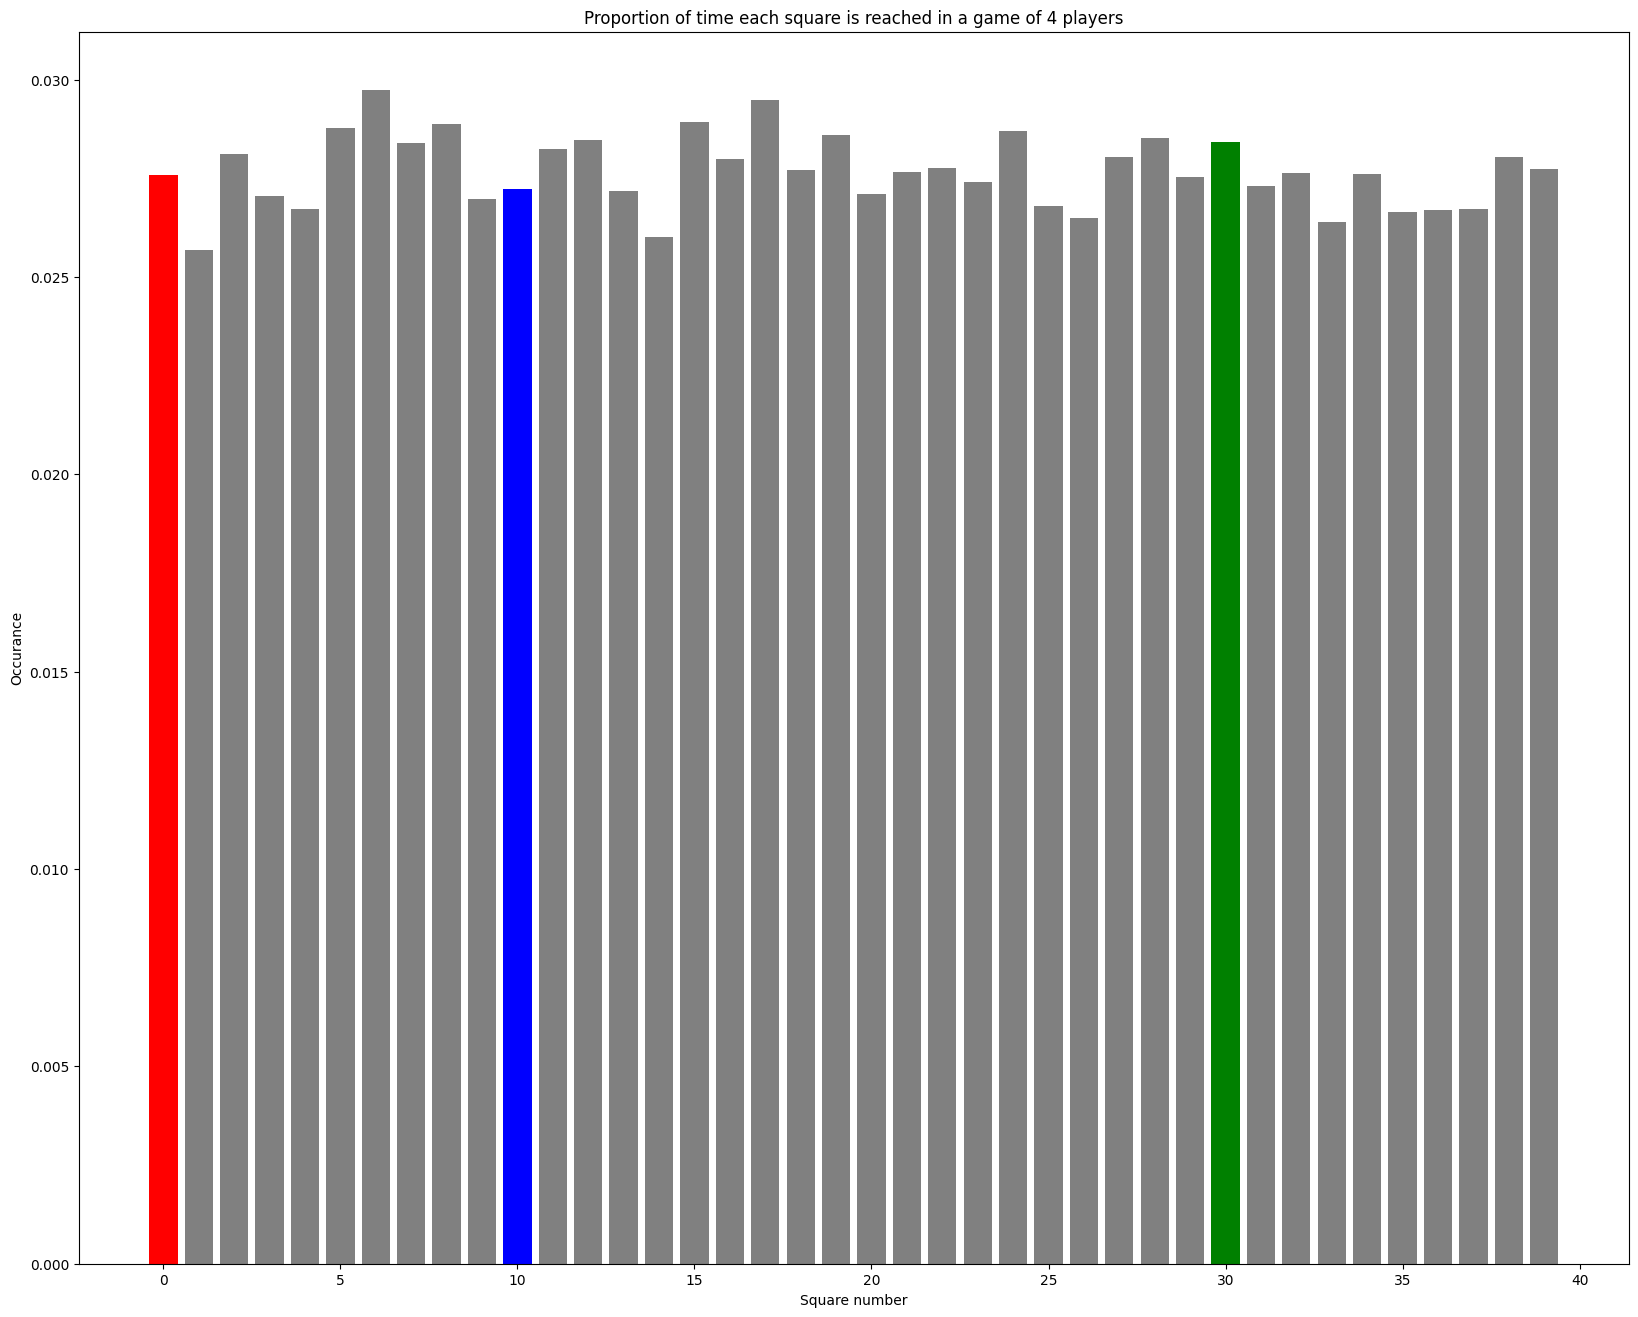

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [61]:
col = ['gray']*40
col[0] = 'red' ## Go
col[10] = 'blue' ## Jail
col[30] = 'green' ## Go to jail

idx = (position_count == max(position_count))

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 16))

plt.bar(x = [i for i in range(40)], height = position_count/(num_iterations * turns * num_players), color = col)
plt.ylabel("Occurance")
plt.xlabel("Square number")
plt.title(f"Proportion of time each square is reached in a game of {num_players} players")
plt.show()